<a href="https://colab.research.google.com/github/gsiraji/omicsPractice/blob/main/genpals_tutorial1_pca_umap_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copy this notebook!

First please copy this notebook to your own Google drive, you won't be able to run it otherwise! Use **File > Save a Copy in Drive**.




# Install required libraries

In [ ]:
# note: more recent versions of scanpy are causing matplotlib issues wtih google colab!!!
! pip install 'scanpy[leiden]==1.6.1' 'scrublet==0.2.3' 'numba==0.52' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 855.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver do

## Make a shortcut to the data folder

Before being able to run the rest of this notebook, you must give colab access to the [data directory](https://drive.google.com/drive/folders/1_ZKcxAGHzKR-WM3l3Ia1g7Ikbqt1f2FK?usp=sharing) by:

1. Follow the above link. Right click the `genpals_data` directory and select `Add shortcut to Drive` to make the data accessible from your drive.

2. Mount your drive by opening the left panel on colab, going to the `Files` menu, and selecting `Mount Drive` at the top right (i**con looks like a folder with the Google Drive logo**). 

3. Run the block below 

4. Once you run it and sign in with your Google account, hit the directory refresh button (icon looks like a folder with a refresh symbol on it) on the bar at the left.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Read downsampled dataset

For the purposes of this module, we'll only use one sample's worth of cells (~4k cells) so that we can quickly test out different parameters for dimensionality reduction and unsupervised learning.

In [ ]:
import anndata 
import scanpy as sc 
import numpy as np 
import pandas as pd 

from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context
import os

In [ ]:
data_dir = "/content/drive/MyDrive/genpals_data/Zhou_2020/"
adata = sc.read('{}adata_unprocessed_AD11.h5ad'.format(data_dir))

# AnnData format

The [AnnData](https://anndata.readthedocs.io/en/latest/) format was developed explicitly for Scanpy. It allows for storage of expression information per cell or sample alongside complex multidimensional metadata about the samples as well as about the genes. 

The basic AnnData format is comprised of:
* `AnnData.obs`: A dataframe with information and metadata about the samples / cells
* `AnnData.var`: A dataframe with information about the genes
* `AnnData.X`: A dataframe with the expression of each gene from `AnnData.var` in each sample from `AnnData.obs`

For those familiar with the [pandas](https://pandas.pydata.org/) Python library, `AnnData.obs` and `AnnData.var` are pandas DataFrames and can be manipulated as such.

Just to give you a quick idea of what this means in practice, let's take a look at each of these structures from our data.

In [ ]:
print(np.shape(adata.obs)) # print the dimensions of the obs table
adata.obs.head() # print the first 5 entries in the obs table

(3786, 16)


,Age,Sex,SampleID,DonorID,Batch,Original_cluster,Dataset,Region,cerad,braak,Condition,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
barcode,,,,,,,,,,,,,,,,
AAACCTGCAAACCCAT-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,AD,1083,1083,1528.0,19.0,1.243456
AAACCTGCAATGTTGC-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,AD,712,712,1719.0,842.0,48.981968
AAACCTGCACGTCAGC-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,AD,664,664,935.0,34.0,3.636364
AAACCTGGTCCGTGAC-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,AD,2038,2038,3250.0,57.0,1.753846
AAACCTGGTCCTAGCG-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,AD,4612,4612,9551.0,257.0,2.690818


In [ ]:
print(np.shape(adata.var)) # print the dimensions of the var table
adata.var.head() # print the first 5 entries in the var table

(28392, 6)


,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13.3,128,False,128,0.001144,99.887406,130.0
RP11-34P13.7,499,False,499,0.004425,99.561060,503.0
RP11-34P13.8,9,False,9,0.000079,99.992083,9.0
RP11-34P13.14,98,False,98,0.000871,99.913795,99.0
FO538757.3,43,False,43,0.000378,99.962176,43.0


In [ ]:
print(np.shape(adata.X)) # print the dimensions of the expression data
# print the expression values for the first 5 genes and first 5 cells

print(adata.X[1:10,1:10])

# we need to use the todense() function here to convert the sparse matrix to a dense matrix
print(print('Datatype:', adata.X.dtype))

print(adata.X[:5, :5].todense() )

print(adata.X[1:10,1:10])


(3786, 28392)
  (1, 4)	3.1086311
  (3, 4)	0.7163806
  (8, 4)	1.9578677
  (8, 7)	0.7960833
Datatype: float32
None
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
  (1, 4)	3.1086311
  (3, 4)	0.7163806
  (8, 4)	1.9578677
  (8, 7)	0.7960833


# Normalization

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

# log normalize the counts matrix:
sc.pp.log1p(adata)

## Compute highly variable genes


After quality control filtering and normalization, we are ready to start finding patterns underlying our dataset. For example, one of our goals is to identify biologically relevant clusters of cells that we can analyze in the context of our system of interest (in this case, Alzheimer's Disease). Here we will go in depth into **dimensionality reduction** and **clustering**. 

It turns out that you do not need to use all of the features (genes) in your dataset to identify underlying patterns. In fact, high dimensionality may actually make it more difficult to find these patterns. scRNA-seq datasets typically have somewhere between 10k and 30k features (genes). Here we will go over how to identify the genes that will help us discriminate each cell type from one another. We generally refer to these as "highly variable genes" (HVGs). In scanpy, we identify HVGs using the function `sc.pp.highly_variable_genes`. You can inspect all of the different options for this function within the notebook using the handy `?` operator, as seen below. Alternatively you can visit the [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) on the web to get the same information.

Scanpy offers three different "flavors", or different approaches of identifying highly variable genes. Not surprisingly based on the name, each of these approaches are using slightly different ways quantifying the variance of each gene in the dataset and then taking all genes above a certain cutoff. The cutoff can be based off of an arbitrary number of genes using the `n_top_genes` parameter, or the user can provide parameters to select genes based on measures of variance (`min_disp`, `max_disp`) or expression (`min_mean`, `max_mean`).  Additionally, we can specify the `batch_key` parameter, which will identify HVGs separately for each batch and then merge the results, attempting to avoid selecting genes that are exclusively expressed in a particular batch.


For the `seurat` and `cell_ranger` flavors, the normalized [dispersion](https://en.wikipedia.org/wiki/Statistical_dispersion) is obtained by scaling with the mean and standard deviation of the dispersions for genes falling into a given bin for mean expression of genes, such that for each bin of expression, HVGs are selecting, so it should not bias only for highly expressed genes. Alternatively, for the `seurat_v3` flavor, a normalized variance is computed for each gene by first [standardizing the data](https://en.wikipedia.org/wiki/Standard_score) (z-score normalization for each gene) with a regularized standard deviation, then ranking genes by the normalized variance.

 Let's go ahead and try running the `sc.pp.highly_variable_genes` function. 

In [ ]:
print(len(adata.var.index))

28392


In [ ]:
# identify highly variable genes:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)


We can see that after running `sc.pp.highly_variable_genes`, `adata.var` now has a few new columns, with slightly different outputs for the different flavors. Importantly, each of the flavors gives an output column `adata.var.highly_variable`, which is a boolean (`True` or `False` value) telling us whether or not each gene was considered highly variable. 

We can visually inspect which genes were selected as highly variable using this information. Scanpy includes a nice plotting function called `sc.pl.highly_variable_genes`, which plots a measure of the average gene expression on the x-axis versus a measure of the variance on the y-axis, and colors the genes based on those that were identified as HVGs.


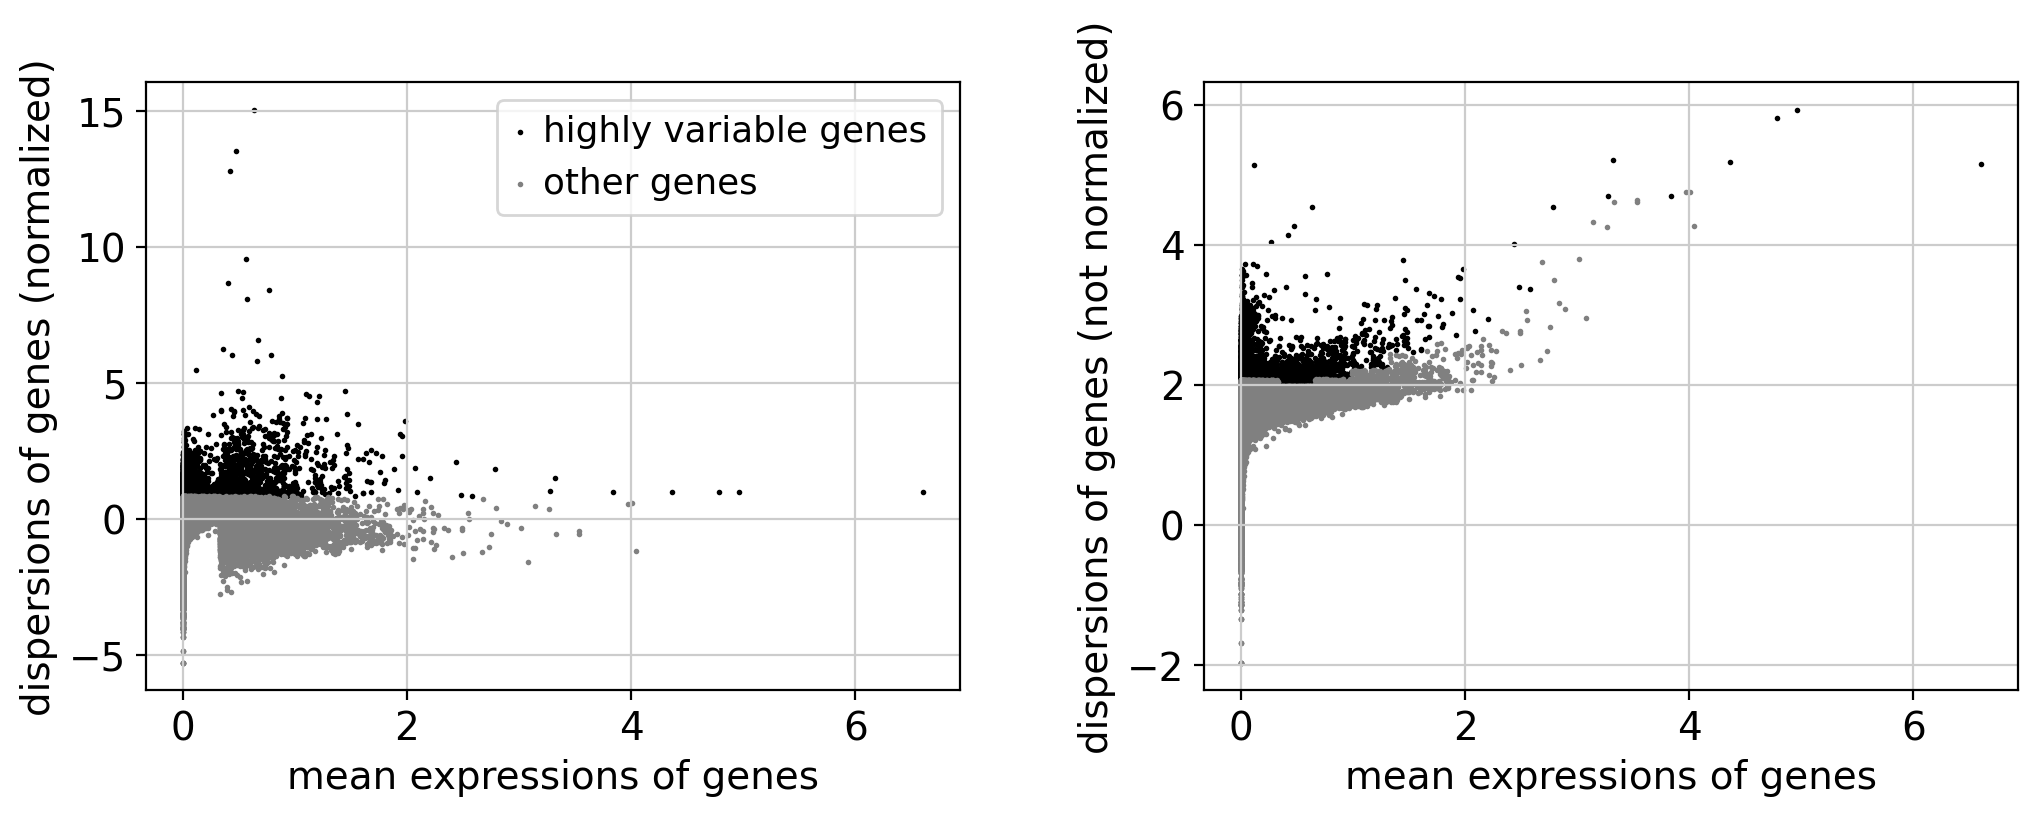

In [ ]:
# change figure settings
sc.settings.set_figure_params(dpi=100, dpi_save=1000, figsize=(6,4), facecolor='white')

# plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var.head()

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
RP11-34P13.3,128,False,128,0.001144,99.887406,130.0,False,2.381714e-03,0.771968,-1.135718
RP11-34P13.7,499,False,499,0.004425,99.561060,503.0,False,3.228770e-02,1.931502,0.621218
RP11-34P13.8,9,False,9,0.000079,99.992083,9.0,False,1.000000e-12,NaN,NaN
RP11-34P13.14,98,False,98,0.000871,99.913795,99.0,False,7.106005e-04,0.406175,-1.689972
FO538757.3,43,False,43,0.000378,99.962176,43.0,False,3.241937e-04,0.205058,-1.994707


In [ ]:
# filter to just get highly variable genes for downstream processing:
adata = adata[:, adata.var.highly_variable]


By identifying HVGs, we have essentially reduced the dimensionality of our dataset by a few thousand features, which will ultimately help us identify relevant cell clusters! In the next section we will go over how to use **Principal Component Analysis** to further reduce the dimensionality of our dataset.

# Linear dimensionality reduction

Here we wil further reduce the dimensionality of our dataset using an approach called [**Principal Component Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis), or **PCA**. PCA will allow us to go from thousands to tens of dimensions for our downstream analysis. However, unlike the previous step, where our dimensions are in genes, each of our dimensions will now be 'principal components'. Of course, principal components are not as biologically interpretable as genes themselves, but they are quite handy for identifying patterns underlying high-dimensional data since they strive to maintain the variance in the original dataset in a more compact space. Furthermore, the individual principal components are linearly uncorrelated from one another, so in general they do a good job at retaining biologically relevant information without redundancy. For example, the *i*th PC is the direction of a line that best fits the data while being orthogonal to the first *i* - 1 vectors. There are actually several approaches for computing PCA, Scanpy uses an approach called [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). 

First, the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) is computed, which is a square matrix giving the covariance between each pair of elements, in this case it will be a matrix describing pairs of HVGs. The covariance matrix is then factorized in terms of its eigenvalues and eigenvectors  ([eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix))
. The principal components are the eigenvectors of the data's covariance matrix.


If your linear algebra is rusty, that is okay, you fortunatley don't need to memorize the exact formulation of PCA or SVD in order to use them effectively! Scanpy makes it very easy to perform PCA using the `sc.tl.pca` function. It is still nice to have a high-level understanding of this process instead of treating it like a magic black box. 



In [ ]:
# scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

# find principal components using highly variable genes 
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
adata.var.head()

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
RP11-54O7.1,138,False,138,0.001231,99.878610,140.0,True,0.005503,2.484509,1.459140,0.001383,0.054630
RP11-54O7.2,3,False,3,0.000026,99.997361,3.0,True,0.002385,2.201835,1.030830,0.000609,0.037489
AURKAIP1,13859,False,13859,0.150260,87.809083,17082.0,True,0.369418,2.025633,1.023290,0.156413,0.482789
RP4-758J18.10,184,False,184,0.001627,99.838146,185.0,True,0.005452,2.426210,1.370804,0.001456,0.054902
VWA1,10005,False,10005,0.101977,91.199212,11593.0,True,0.304423,2.301227,1.181429,0.102549,0.442358


The number of PCs to include for downstream analysis is an important parameter to consider. Fortunately this is not an extremely sensetive parameter, so it is not critical that you select the "right number". We can plot the variance captured by each PC to get an idea of how many PCs to include using the `sc.pl.pca_variance_ratio` function.

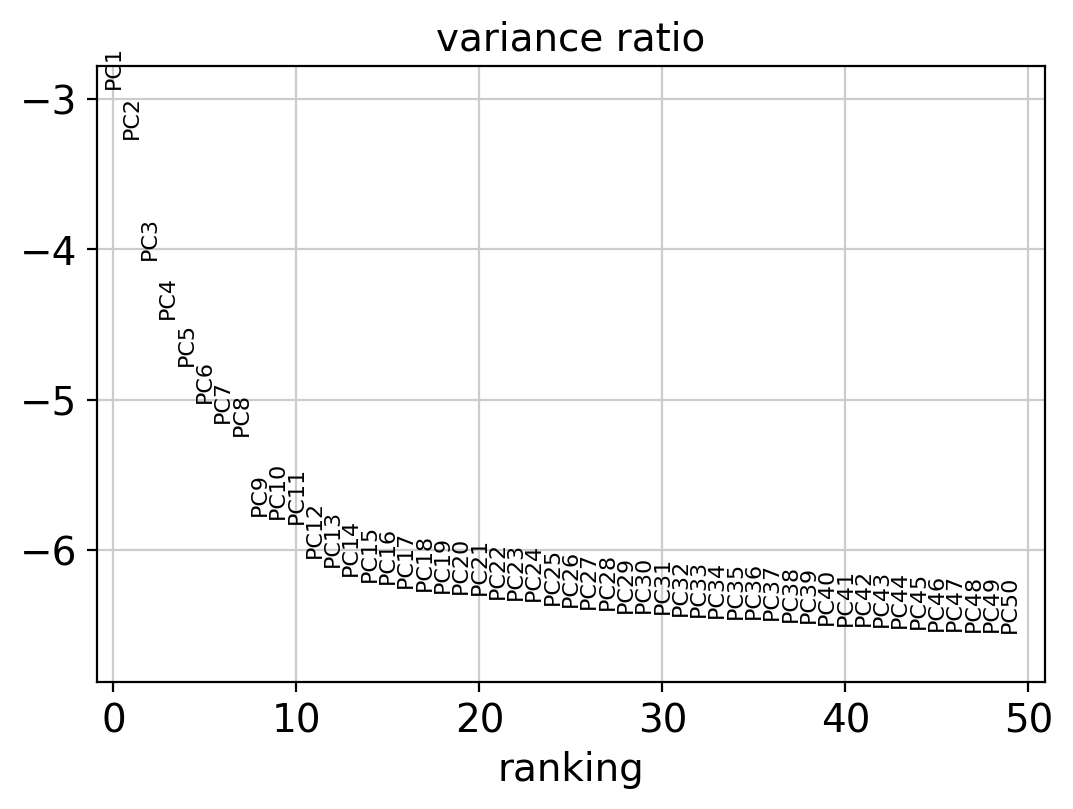

In [ ]:
# plot the variance ratio for each computed PC
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

There is a point where we are getting diminishing returns on the variance contained by each PC. We generally want to find the 'elbow' in this plot and then pick the top PCs based on that elbow for downstream analysis.

It is often useful to visualize the top two principal components. In bulk RNA-seq, the top two PCs are often used to visualize different samples and experimental conditions in a nice compact 2D figure. However, given that we have many thousands of cells in a scRNA-seq study, visualizing PCA is a lot more crowded and ultimately not as good for visualization as it is in bulk RNA-seq. Nevertheless, let's make some PCA plots to try and see if we have uncovered any patterns in the data thus far.

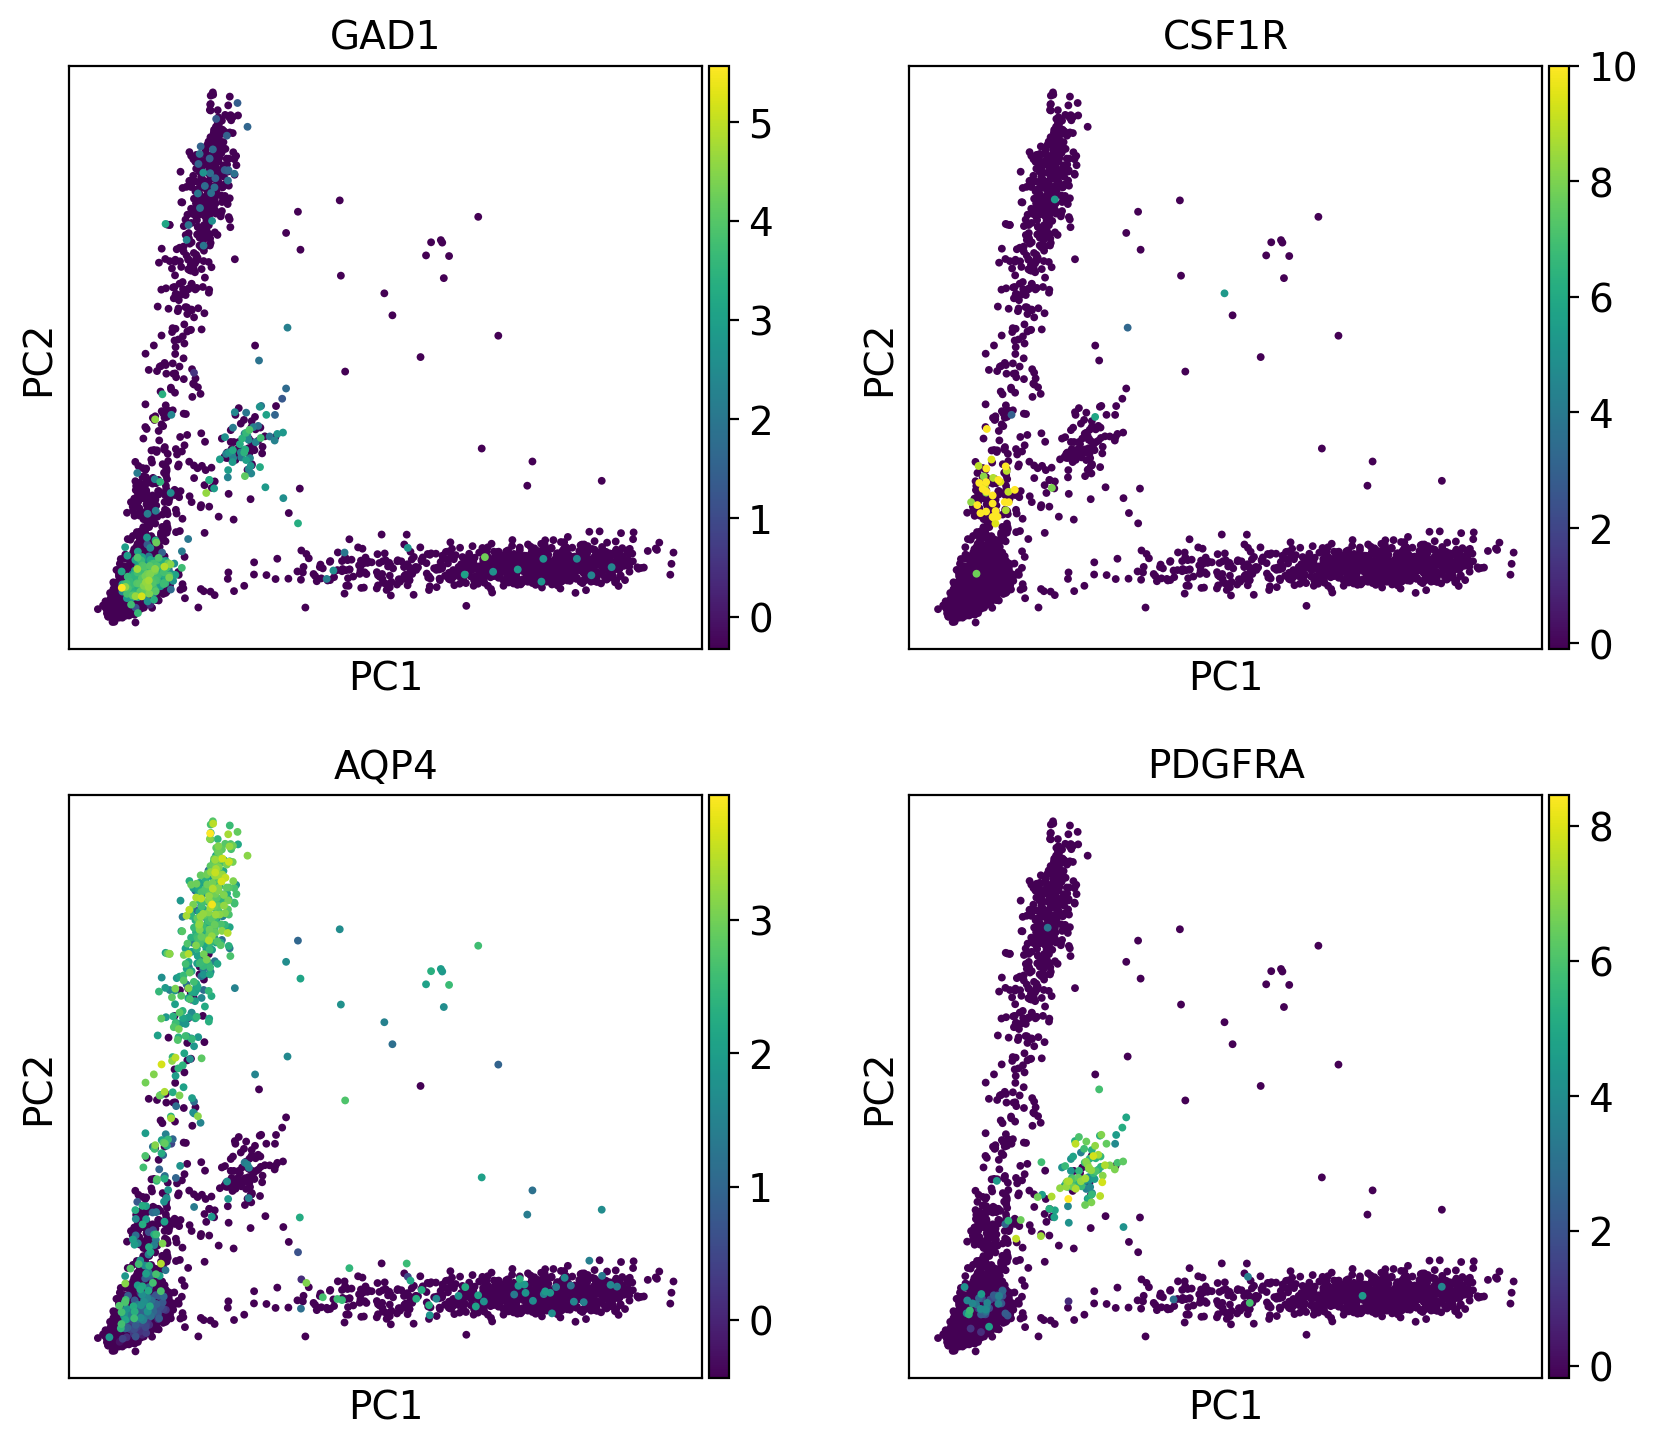

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000, figsize=(4,4), facecolor='white')

# color PCA plot by cell-lineage marker genes
sc.pl.pca(adata, color=['GAD1', 'CSF1R', 'AQP4', 'PDGFRA'], ncols=2)

# Nonlinear low-dimensional embedding and clustering

If you have gotten this far, you have probably seen a nice 2D "cell atlas" image with distinct groups of cells and a lot of nice colors. As we have seen above, even though we have dramatically reduced the dimensionality of our dataset by finding HVGs and running PCA, we have yet to make a clean 2D visualization separating our different cell populations. The 2D PCA plot (which is a linear method of dimensionality reduction) shows clear separation based on certain marker genes but does not yield clear groups of cells that can be analyzed together or assigned a cell type. 

Fortunately, non-linear dimensionality reduction methods exist to enable low-dimensional representations of complex datasets that result in similar cells being grouped together, such as UMAP. 

We won't go into the specific math behind UMAP but to summarize, UMAP constructs a [graph](https://en.wikipedia.org/wiki/Graph_(abstract_data_type)) with connections between cells depending on how close those cells are in gene expression space. The amount of distance that each cell will search for cells to connect to in gene expression space is governed by the distances to the closest _n_ nearest neighbors for each cell. Once this graph is constructed, the UMAP algorithm will create an optimal low-dimensional representation of the graph. This results in a representation that preserves local structure excellently, and preserves global structure much better than tSNE does.

Check out [this article](https://pair-code.github.io/understanding-umap/) for more information on understanding the theory behind UMAP and the advantages of it over tSNE. Figure 3 on this webpage is particularly useful for visualizing the effect of different values for the `n_neighbors` parameter.

To create a UMAP representation of your data, you first have to compute the neighborhood graph. Here, you can specify how many dimensions you'd like to use from the computed principal components, as well as how many nearest neighbors you'd like to consider.

Then, compute the UMAP, which will automatically use the neighbors graph computed in the previous step. 

Finally, we'll visualize what this looks like.

In [ ]:
# compute the neighborhood graph:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, metric='cosine')

# compute UMAP
sc.tl.umap(adata)


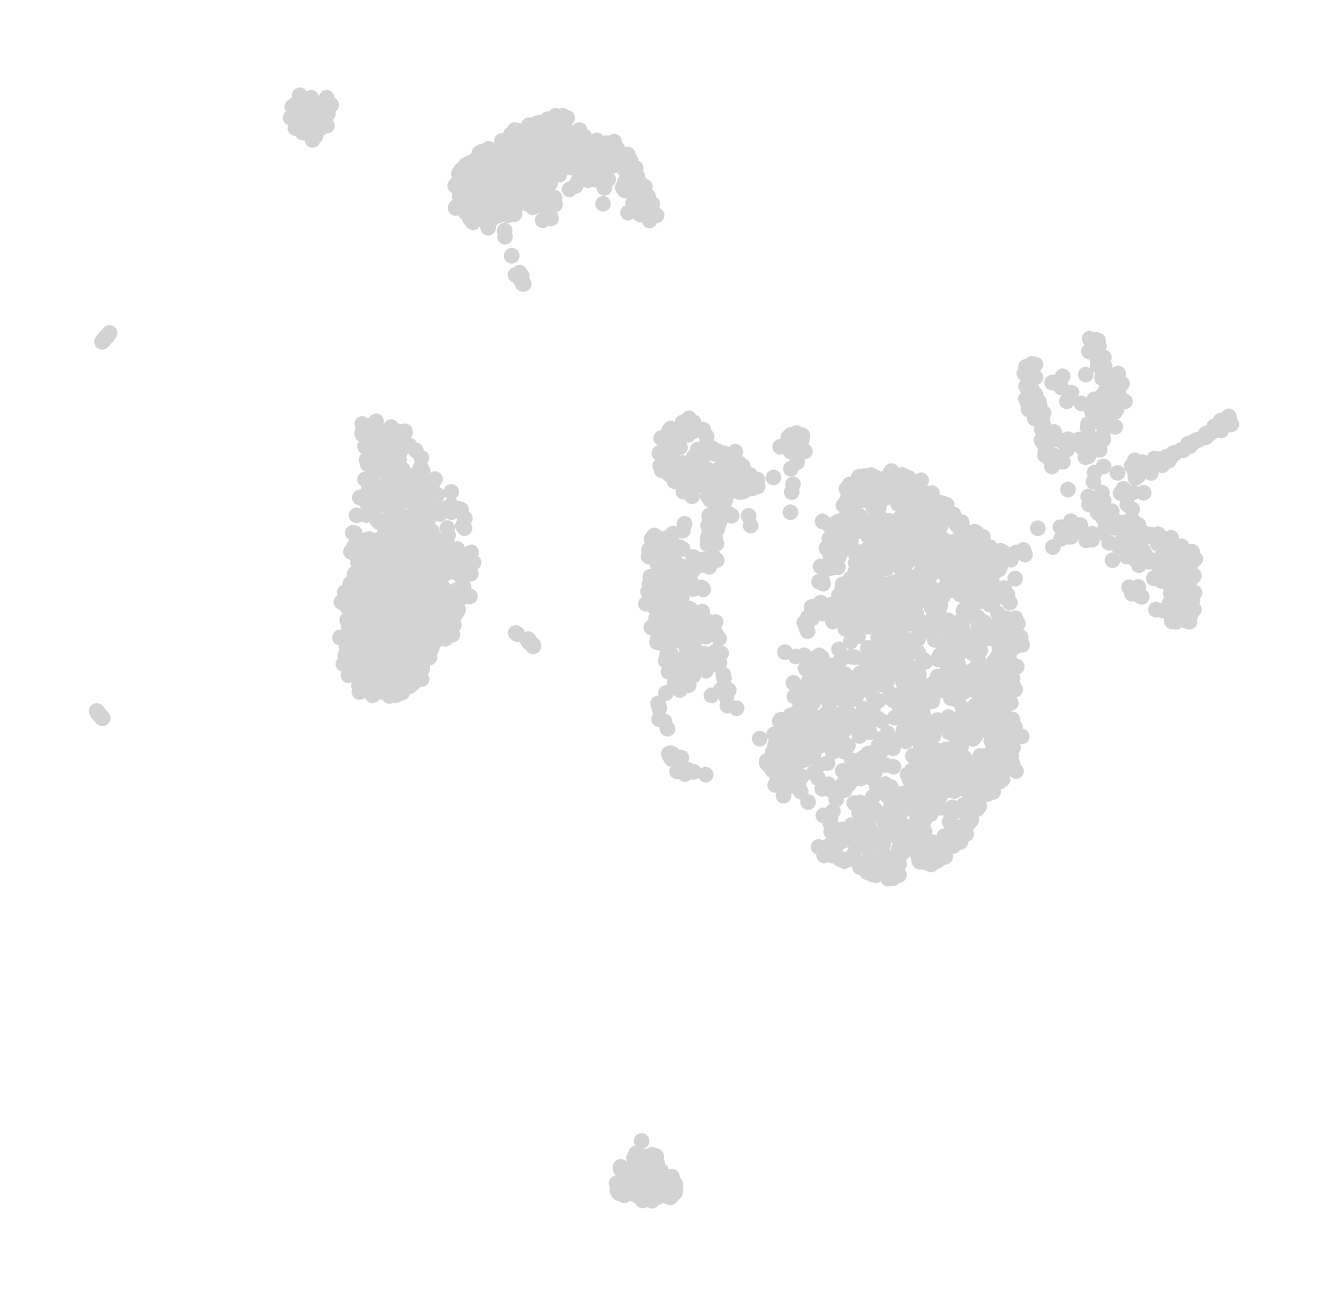

In [ ]:
# plot the UMAP
sc.settings.set_figure_params(dpi=200, dpi_save=1000, figsize=(4,4), facecolor='white')

sc.pl.umap(adata, frameon=False, title='')

As you can see, even though we don't know what exactly each group of cells is in this representation, it's a lot easier to visually resolve groups of related cells than in the PCA 2D representation.

Finally, we want to associate our cells into discrete groups based on their gene expression profiles. This is a process known as clustering. There are many different types of clustering, but typically either the Leiden or Louvain clustering algorithms are used in single cell applications, with the former being more popular in recent years. Leiden clustering, like many clustering algorithms, uses iteration to inch cluster assignments towards an optimum. 

For our purposes, we should worry about the `resolution` parameter most. The resolution of the clustering will determine the granularity of the clusters. A higher resolution will result in more clusters, which functionally might result in you getting more clusters of specific cell subtypes or transcriptomic states that still belong to one major cell type. Lower resolutions however will functionally correspond to clusters that are more broadly defined and therefore may include a large population of one cell type. 

The resolution parameter is critical to nail down depending on how many cell types you're expecting to see in your data. For instance, if you're sequencing a homogenous cell line, you may expect to see fewer cell types and might choose a lower resolution. In contrast, you might be sequencing a highly-complex tissue sample that has many different cell types and sub-cell type populations that you want to characterize. Typically the process of choosing clustering resolution is more of an art than a science and typically involves choosing one resolution, then trying to annotate your cell types of interest. If you see celltypes that are missing or that are extra compared to what you expected, these might be signs to either increase or decrease the resolution respectively.

Here, we'll just try with `resolution=1` to start.

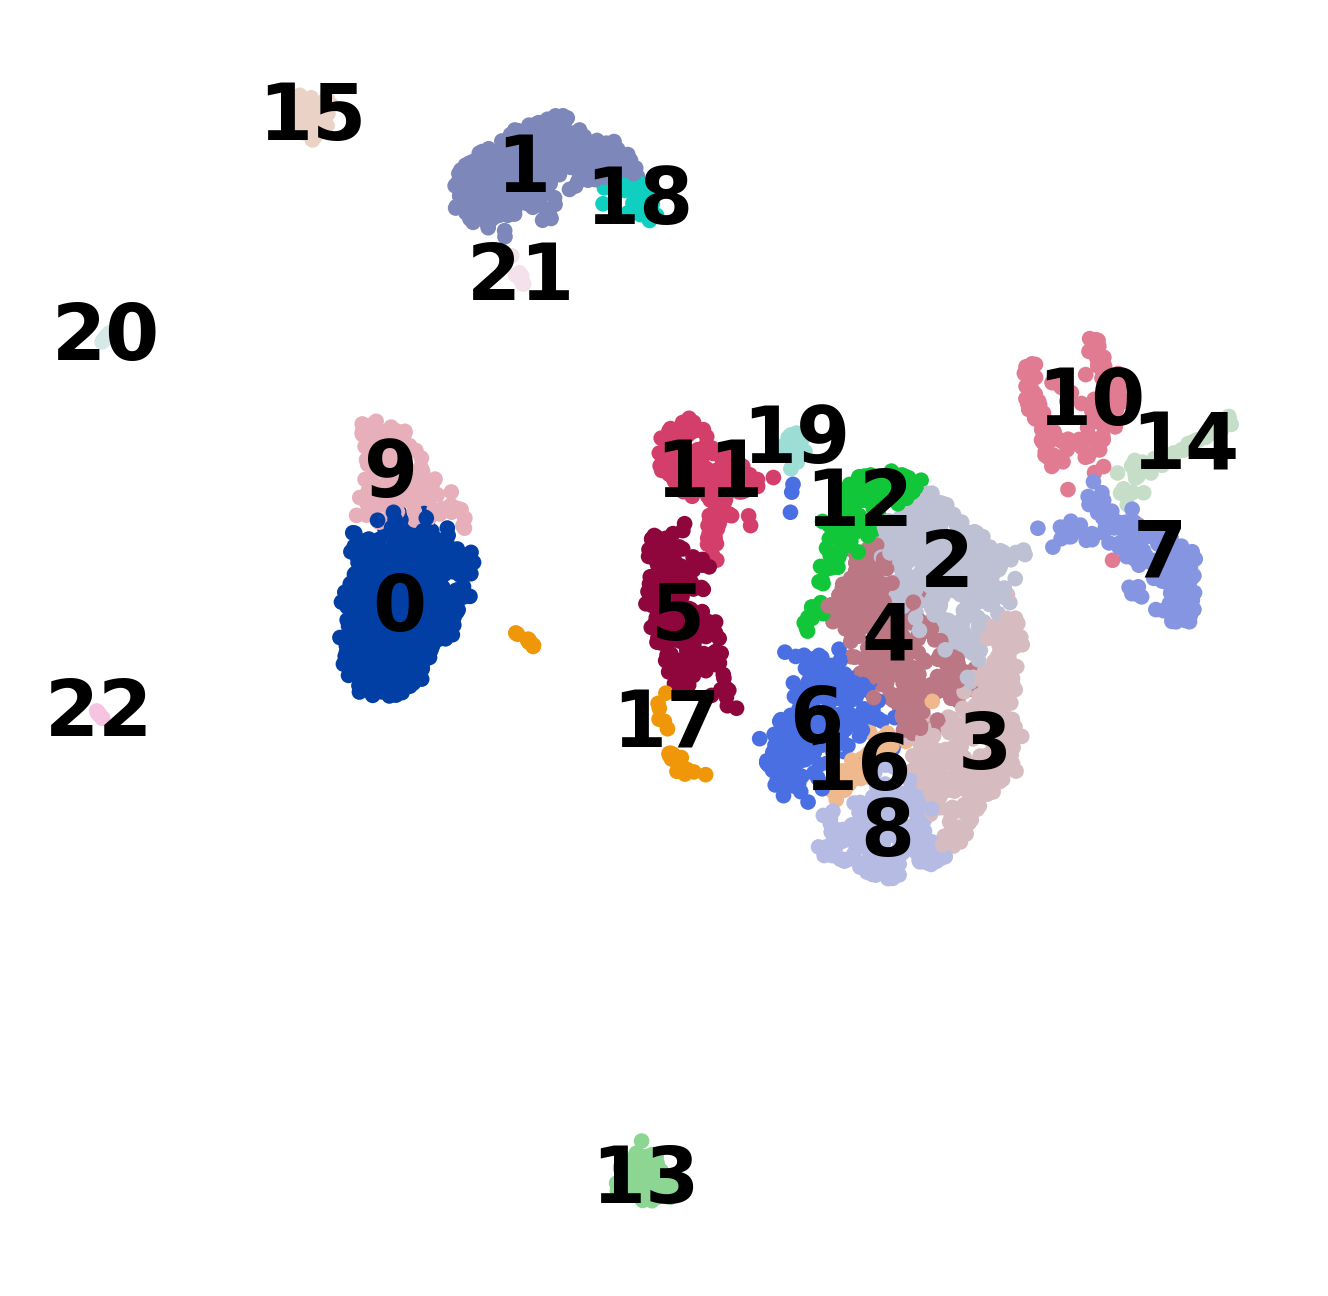

In [ ]:
# clustering
sc.tl.leiden(adata, resolution=1)

# plot clusters on UMAP:
sc.pl.umap(adata, color='leiden', legend_loc='on data', frameon=False, title='')

# Parameter searches

The functions below are designed so you can visualize what the effect of choosing different parameters has on the 2-dimensional representation and clustering of the data. Note that these take a few minutes to run, so a few blocks have already been run for you and have output that you can see. You can run your own as well though!

First, read the unprocessed dataset back in.

In [ ]:
data_dir = "/content/drive/MyDrive/genpals_data/Zhou_2020/"
adata = sc.read('{}adata_unprocessed_AD11.h5ad'.format(data_dir))

In [ ]:
def test_params(adata, ax=None, hvgs=3000, pcs=50, nns=10, res=1,
                xlabel='', ylabel=''):
  """
  Parameters:
    adata (anndata AnnData): AnnData with raw unprocessed expression data
    ax (matplotlib Axes): Axes to plot on
    hvgs (int): How many highly-variable genes to consider
    pcs (int): How many principal components to consider
    nns (int): How many nearest neighbors to consider
    res (int): Cluster resolution
    xlabel (str): label to display on x axis
    ylabel (str): label to display on y axis
  """

  # make sure we don't modify input
  adata = adata.copy()

  # normalize and scale data, identify hvgs
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=hvgs)
  adata = adata[:, adata.var.highly_variable]
  sc.pp.scale(adata, max_value=10)

  # PCA 
  sc.tl.pca(adata, n_comps=pcs, svd_solver='arpack')

  # nearest neighbors
  sc.pp.neighbors(adata, n_neighbors=nns, n_pcs=pcs, metric='cosine')

  # UMAP
  sc.tl.umap(adata)

  # clustering
  sc.tl.leiden(adata, resolution=res)

  # plotting UMAP by cluster
  sc.settings.set_figure_params(dpi=200, dpi_save=1000, figsize=(4,4), facecolor='white')
  if ax:
    ax = sc.pl.umap(adata, color='leiden', frameon=True, 
              ax=ax, show=False)
  else:
    ax = sc.pl.umap(adata, color='leiden', frameon=True, show=False)

  ax.get_legend().remove()
  ax.set_title(xlabel)
  ax.set_xlabel('')
  ax.set_ylabel(ylabel)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

In [ ]:
def param_search(adata, hvgs=None, pcs=None, nns=None, res=None):
    """
    Parameters:
      adata (anndata AnnData): AnnData with raw unprocessed expression data
      hvgs (None or list of int): How many highly-variable genes to consider
      pcs (None or list of int): How many principal components to consider
      nns (None or list of int): How many nearest neighbors to consider
      res (None or list of int): Cluster resolution
      * from the arguments with type "None or list of int", only provide two!
    """
    params = {'hvgs': hvgs,
                  'pcs': pcs,
                  'nns': nns,
                  'res': res}
    param_names = []
    param_count = 0
    for param, item in params.items():
      if item != None:
        param_count += 1
        param_names.append(param)
    if param_count != 2: 
      raise ValueError('Please provide two parameters to test')

    # default parameter values
    val_dict = {'hvgs': 3000,
                'pcs': 50,
                'nns': 10,
                'res': 1}

    param1 = param_names[0]
    param2 = param_names[1]

    fig = plt.figure(figsize=(4,4))
    nrow = len(params[param1])
    ncol = len(params[param2])

    # loop through parameters
    n = 1
    for i, val1 in enumerate(params[param1]):
      for j, val2 in enumerate(params[param2]):
        val_dict[param1] = val1
        val_dict[param2] = val2
        ax = fig.add_subplot(nrow, ncol, n)
        if i == 0:
          xlabel = '{}={}'.format(param2, val2)
        else:
          xlabel = ''
        
        if j == 0:
          ylabel = '{}={}'.format(param1, val1)
        else: 
          ylabel = ''

        _ = test_params(adata, ax=ax,
                    hvgs=val_dict['hvgs'],
                    pcs=val_dict['pcs'],
                    nns=val_dict['nns'],
                    res=val_dict['res'],
                    xlabel=xlabel, 
                    ylabel=ylabel)
        n += 1

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/

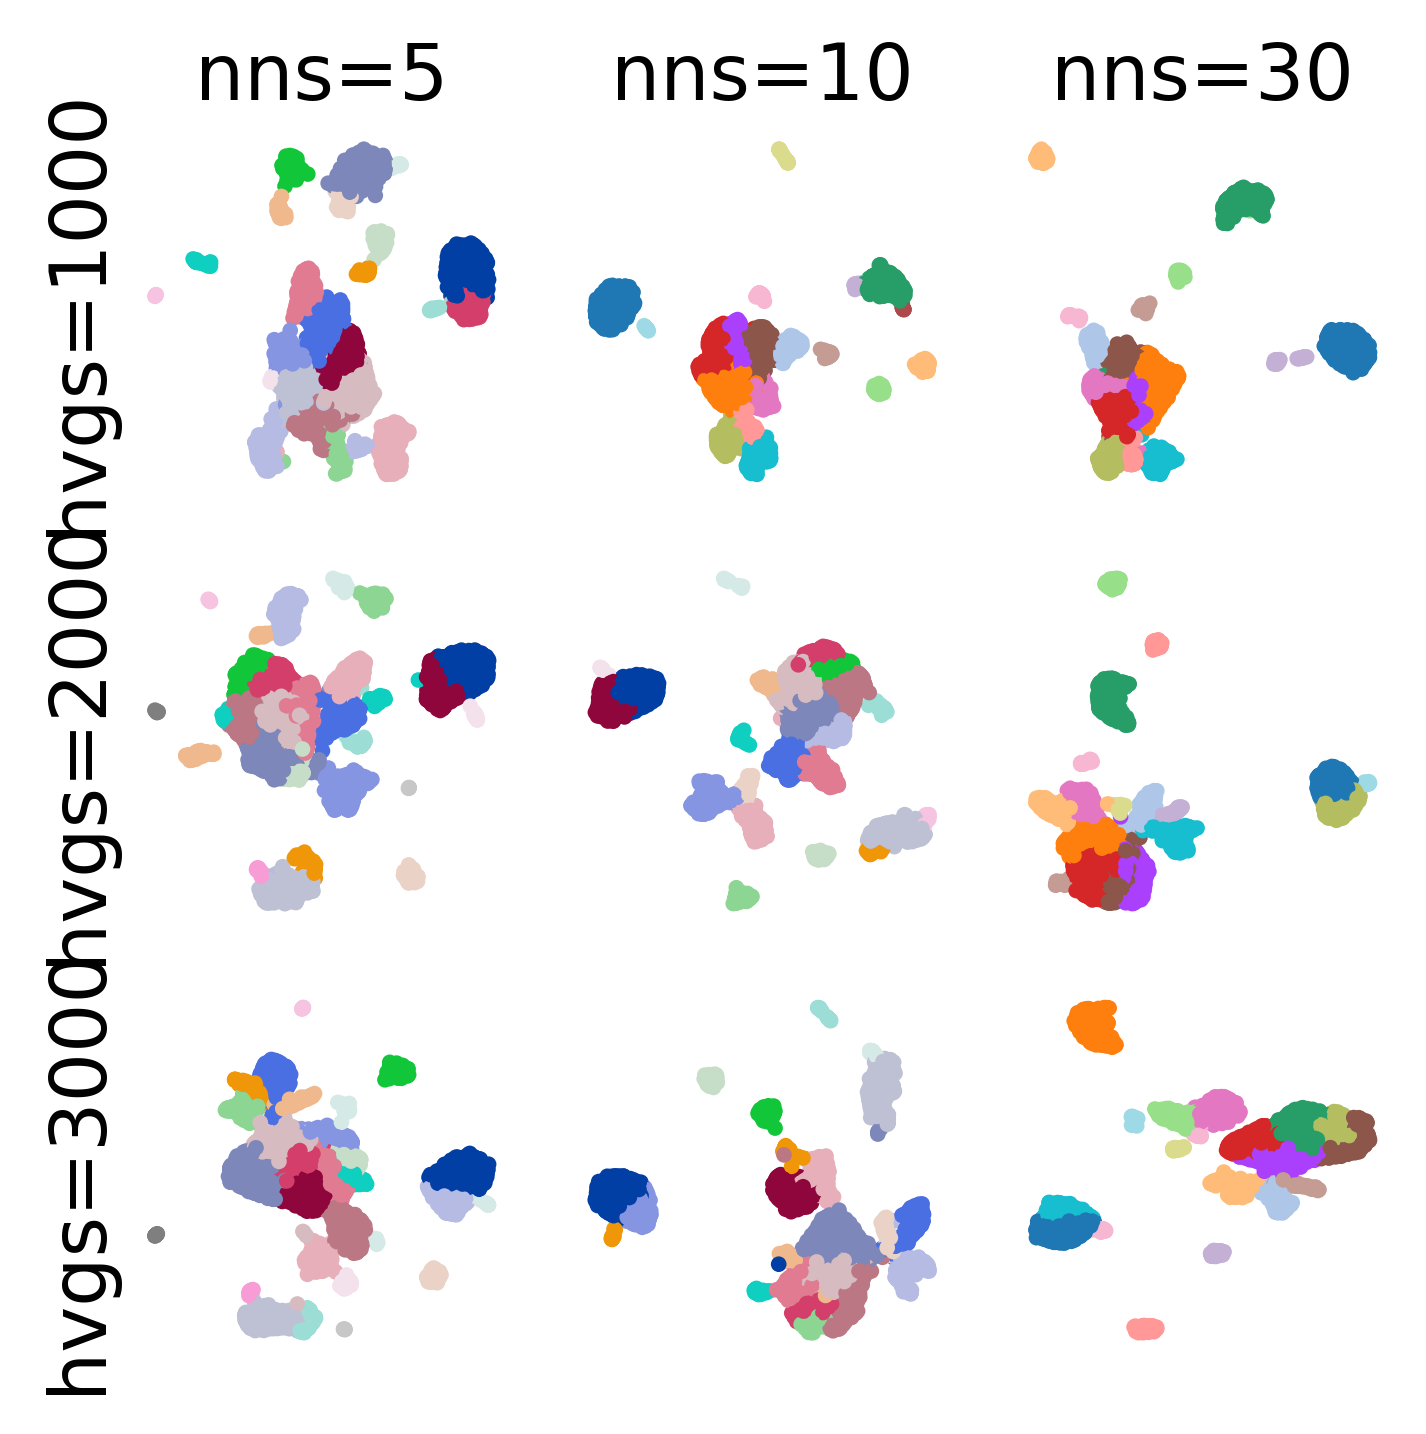

In [ ]:
param_search(adata, hvgs=[1000, 2000, 3000], nns=[5, 10, 30])

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


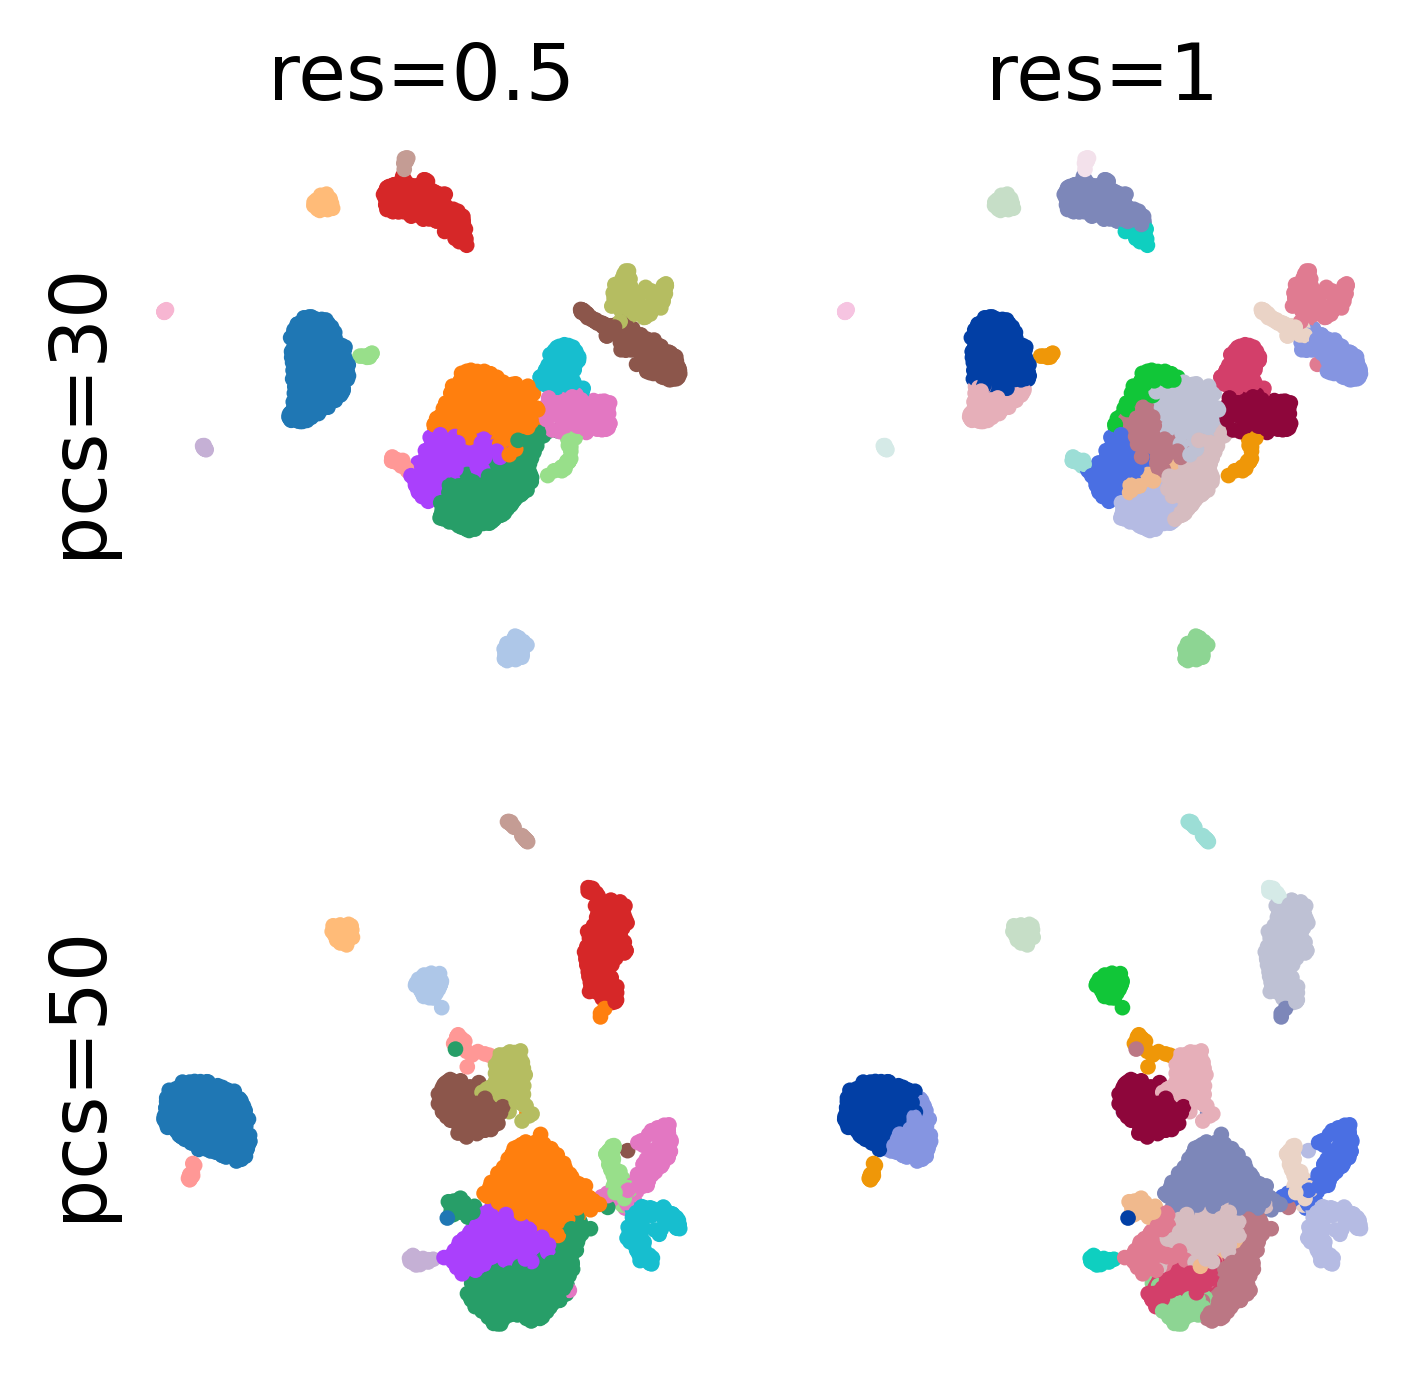

In [ ]:
param_search(adata, pcs=[30,50], res=[0.5, 1])

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


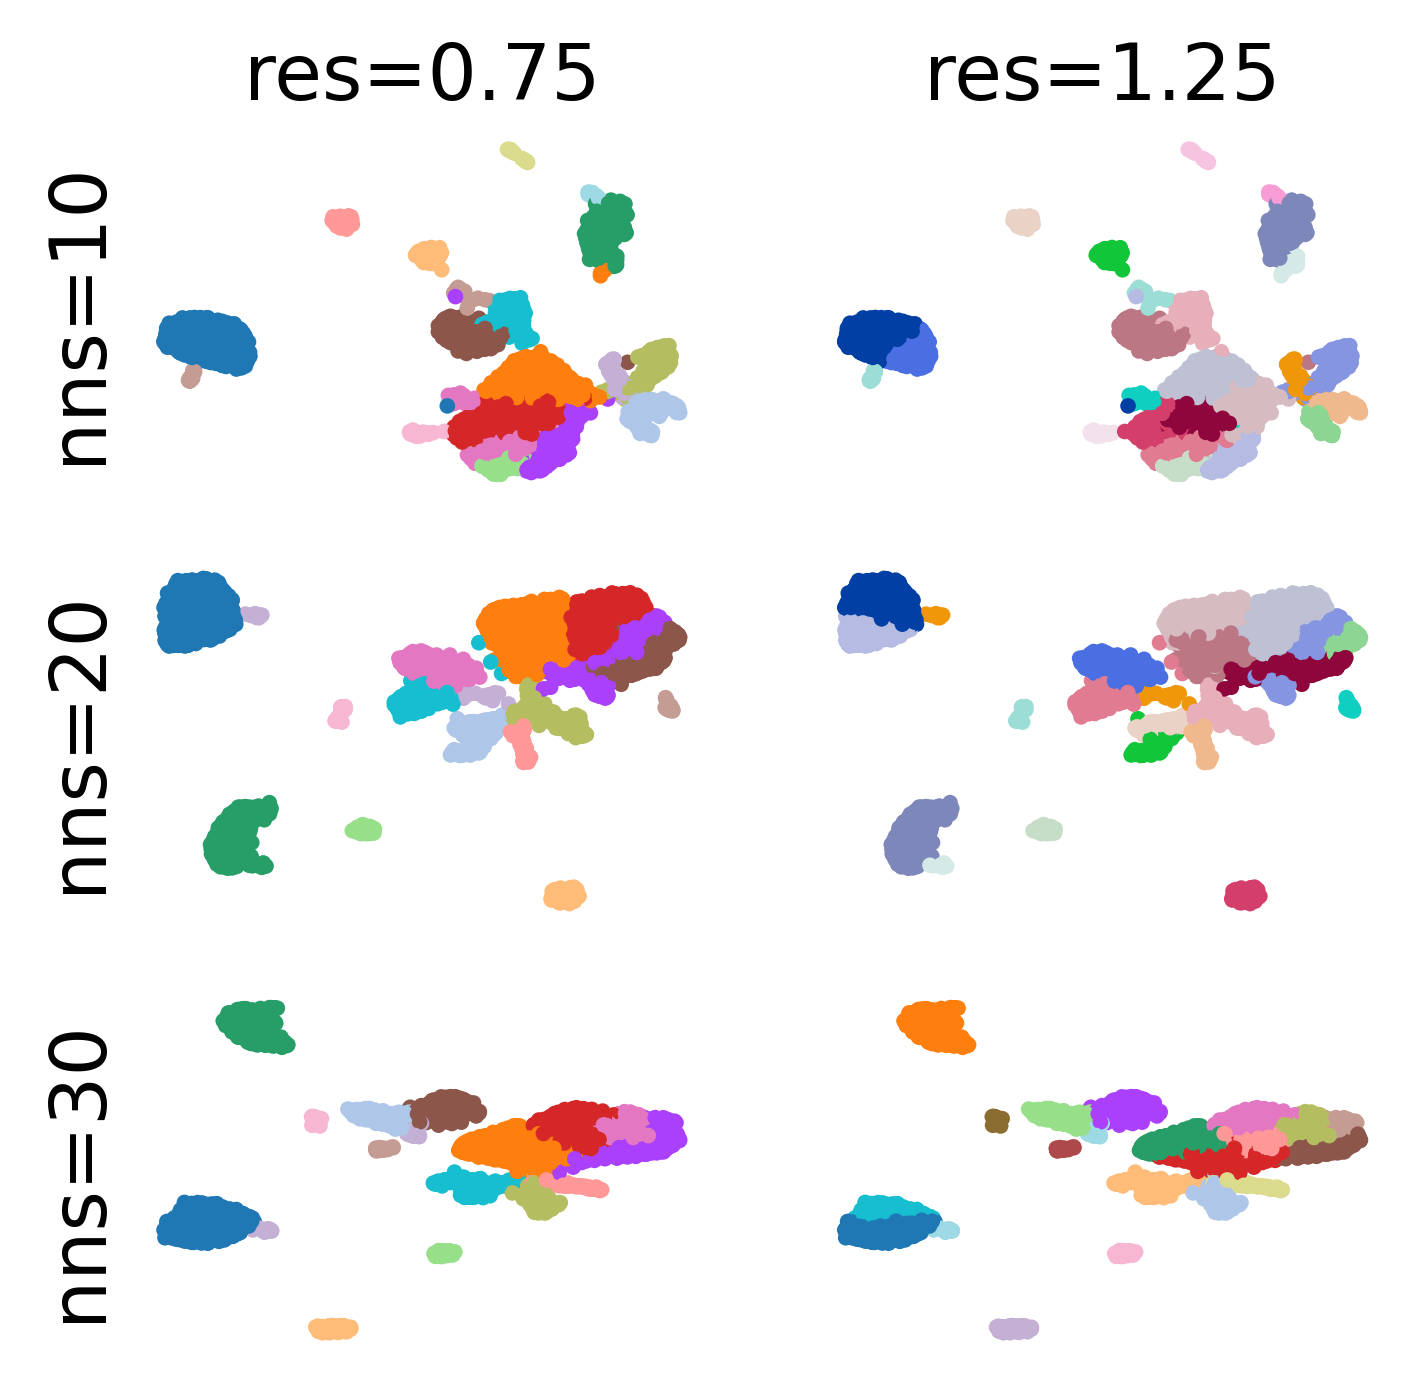

In [ ]:
param_search(adata, nns=[10,20,30], res=[.75, 1.25])


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


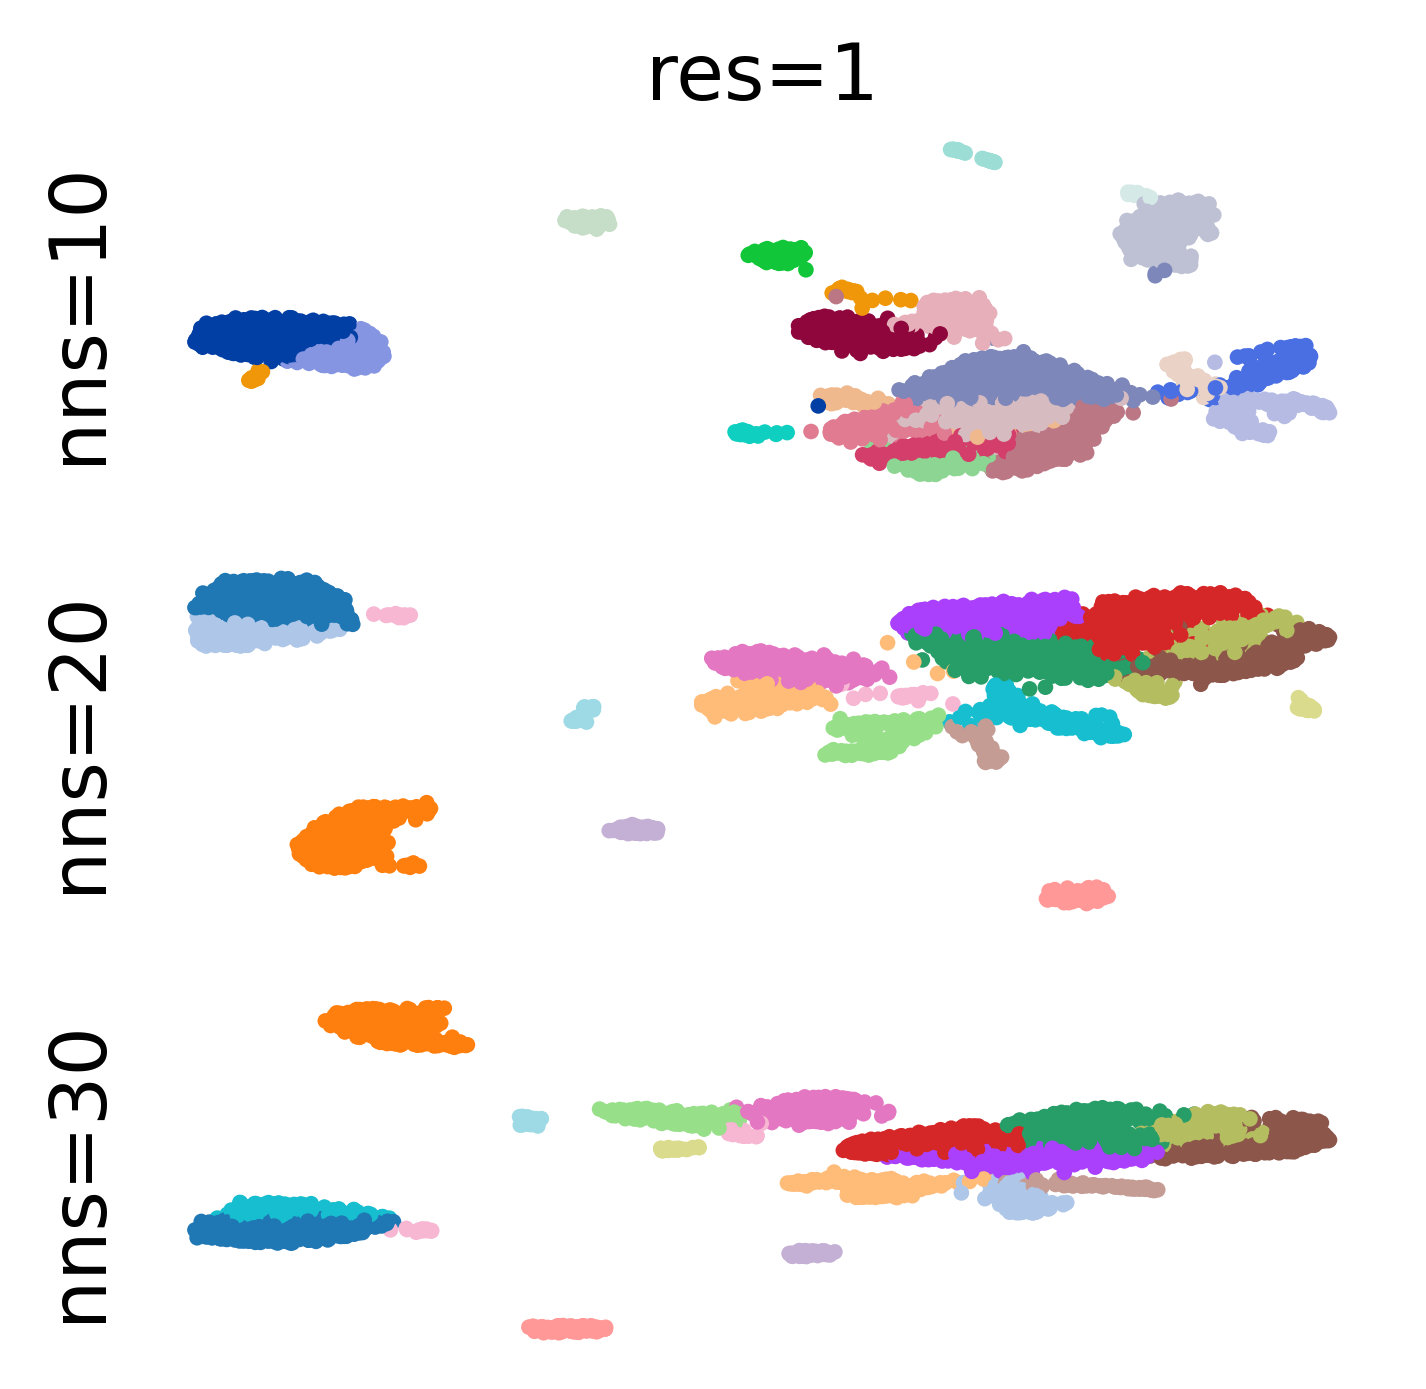

In [ ]:
param_search(adata, nns=[10,20,30], res=[1])

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


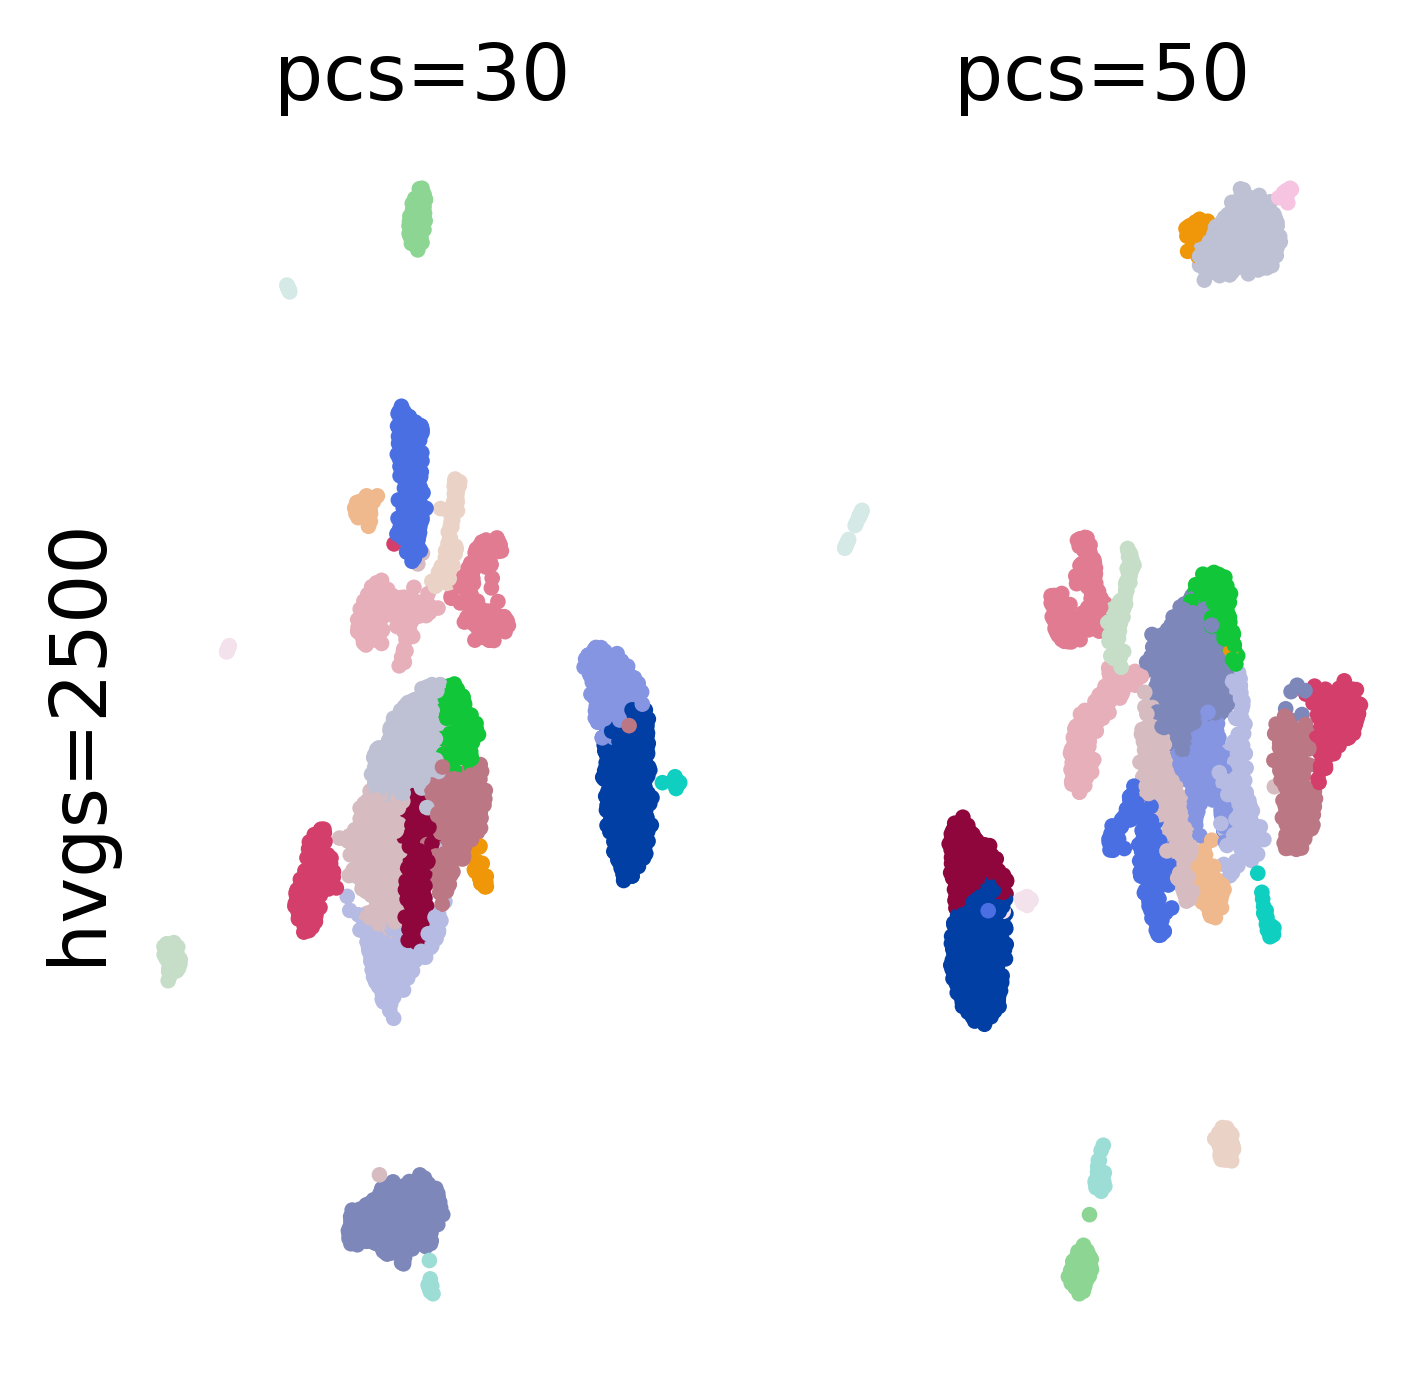

In [ ]:
param_search(adata, pcs=[30,50], hvgs=[2500])
